In [13]:
import sys
sys.path.append('/opt/project/KG_Assist_LLM')

In [14]:
import autogen
from functionals.setting import ModelConfig
from functionals.llm_promot import data_process
from functionals.standard_log import log_to_file

In [15]:
config = ModelConfig()
config_list = [
    {
        "model": "gpt-3.5-turbo",
        "base_url": "https://api.openai-hk.com/v1",
        "api_type": "openai",
        "api_key": config.openaiHk['api_key'],
        "temperature": 0.2,
    }
]
llm_config = {"config_list": config_list}

In [16]:
user_proxy = autogen.ConversableAgent(
    name="MessageForwarderAgent",
    system_message="You are a message forwarder, and your task is to forward the received messages unaltered to the next recipient.",
    llm_config=False,  # 不使用LLM生成回复
    code_execution_config=False,  # 禁用代码执行
    human_input_mode="NEVER",  # 不请求人工输入
)

In [17]:
semantic = autogen.ConversableAgent(
    name="semantic",
    llm_config=llm_config,
    system_message="""Please analyze and predict the users' MBTI personality types from a semantic perspective, with the number of predictions not exceeding five.""",
    description="""Semantic expert, skilled in analyzing user information from a semantic angle to predict their MBTI personality type.""",
    human_input_mode="NEVER",
)

In [18]:
sentiment = autogen.ConversableAgent(
    name="sentiment",
    llm_config=llm_config,
    system_message="""Please analyze and predict the users' MBTI personality types from a sentiment perspective, with the number of predictions not exceeding five.""",
    description="""sentiment expert, skilled in analyzing user information from a sentiment angle to predict their MBTI personality type.""",
    human_input_mode="NEVER",
)

In [19]:
linguistic = autogen.ConversableAgent(
    name="linguistic",
    llm_config=llm_config,
    system_message="""Please analyze and predict the users' MBTI personality types from a linguistic perspective, with the number of predictions not exceeding five.""",
    description="""linguistic expert, skilled in analyzing user information from a linguistic angle to predict their MBTI personality type.""",
    human_input_mode="NEVER",
)

- csv里面取出第一个数据
- 这里简单的清洗了下网址

In [20]:
task = ""
for i, (mbti_type, txt) in enumerate(config.mbti_data.values):
    if i != 0:
        continue
    task = data_process(txt)

In [21]:
def chat_unit(sender, recipient, message):
    return {
        "sender": sender,
        "recipient": recipient,
        "message": message,
        "summary_method": "reflection_with_llm",
        "max_turns": 1,
        "clear_history": True
    }


先每个agent进行一次独立对话

In [22]:
from autogen import initiate_chats

first_chats = [
    initiate_chats([ 
    chat_unit(user_proxy, first_chat, task),
]) for first_chat in [semantic, sentiment, linguistic]
]



********************************************************************************
Starting a new chat....

********************************************************************************
MessageForwarderAgent (to semantic):

'
enfp and intj moments    sportscenter not top ten plays    pranks
What has been the most life-changing experience in your life?
     On repeat for most of today.
May the PerC Experience immerse you.
The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   
Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...
84389  84390     ...
Welcome and stuff.
  Game. Set. Match.
Prozac, wellbrutin, at least thirty minutes of moving your legs (and I don't mean moving them while sitting in your same desk chair), weed in moderation (maybe try edibles as a healthier alternative...

这里我每次把上一轮三个agent的回复整合成一个句子，然后作为新的输附在原文的后面
预测结果放在最后面

In [ ]:
def circle_chat(chats, nums, chat_result, max_depth=3):
    if nums >= max_depth:
        return chat_result

    # 重复一遍
    chat_prompts = []
    for chat in chats:
        chat_content = chat[0].chat_history[1]
        message = f"""The following are speculations from {chat_content['name']} experts, just for reference, you can stick to your own opinion.:
    {chat_content['content']}"""
        chat_prompts.append(message)

    combined_prompt = "\n".join(chat_prompts)

    # 初始化下一轮的聊天
    next_chats = [
        initiate_chats([
            chat_unit(user_proxy, chat_agent, f"""{task}\n\n{combined_prompt}""")
        ]) for chat_agent in [semantic, sentiment, linguistic]
    ]

    return circle_chat(next_chats, nums + 1, combined_prompt, max_depth)



final_chat_result = circle_chat(first_chats, 1, "", 3)


********************************************************************************
Starting a new chat....

********************************************************************************
MessageForwarderAgent (to semantic):

'
enfp and intj moments    sportscenter not top ten plays    pranks
What has been the most life-changing experience in your life?
     On repeat for most of today.
May the PerC Experience immerse you.
The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   
Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...
84389  84390     ...
Welcome and stuff.
  Game. Set. Match.
Prozac, wellbrutin, at least thirty minutes of moving your legs (and I don't mean moving them while sitting in your same desk chair), weed in moderation (maybe try edibles as a healthier alternative...

- token消耗很快
- 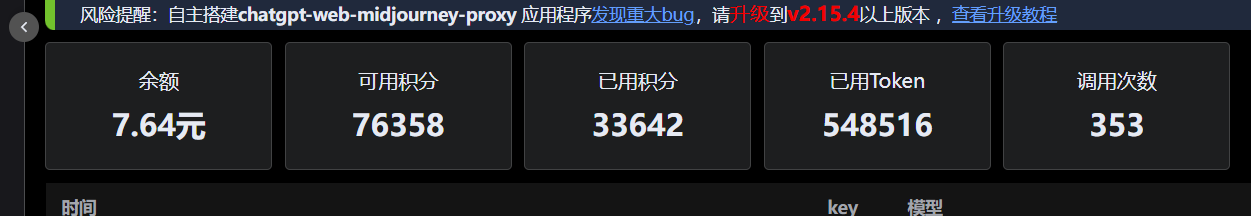

In [24]:
final_chat_result.split("\n")

['The following are speculations from semantic experts, just for reference, you can stick to your own opinion.:',
 "    Based on the semantic analysis of the user's messages, I predict the following potential MBTI personality types:",
 '',
 "1. ENFP: The user's playful tone, varied interests, and focus on personal growth suggest an ENFP personality type. They seem to enjoy discussing experiences, emotions, and engaging in creative activities.",
 '',
 "2. INFJ: The user's introspective comments, empathy towards others, and reflective nature indicate a potential INFJ personality type. They appear to value deep connections and introspection.",
 '',
 "3. INTJ: The user's analytical approach to learning from failures, strategic thinking, and mention of an INTJ friend align with traits commonly associated with the INTJ personality type. They seem to value efficiency and logical reasoning.",
 'The following are speculations from sentiment experts, just for reference, you can stick to your own